# Univariant Prediction

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sklearn
from scipy import stats
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import median_absolute_error
from datetime import date
from sklearn.preprocessing import MinMaxScaler


In [5]:
df=pd.read_csv('Fractionator.csv')

In [6]:
df['Time']=pd.to_datetime(df['Time'])

In [7]:
df=df[(np.abs(stats.zscore(df["AI_2020_OVERHEAD_C5'S_MOL"])) < 3)]

In [8]:
list(df.columns)

['Time',
 "AI_2020_OVERHEAD_C5'S_MOL",
 "AI_2021_MIDDLE_C7'S_MOL",
 "AI_2022_BOTTOM_C3'S_MOL",
 'FIC_2100_PV_FEED_FURNACE_FUEL_SCFH',
 'FIC-2101_PV_TOP_PRODUCT_MBBL/D',
 'FIC_2102_PV_BOTTOM_PRODUCT_MBBL/D',
 'FI-2005_PV_FEED_FLOW_MBBL/D',
 'FIC-2001_SP_TOP_REFLUX_SETPOINT_MBBL/D',
 'FIC-2001_OP_TOP_REFLUX_OUTPUT_%',
 'FIC_2001_PV_TOP_REFLUX_SETPOINT_MBBL/D',
 'FIC-2002_SP_MIDDLE_PRODUCT_DRAW_SETPOINT_MBBL/D',
 'FIC_2002_OP_MIDDLE_PRODUCT_DRAW_OUTPUT_%',
 'FIC_2002_PVMIDDLE_PRODUCT_DRAW_MBBL/D',
 'FIC_2004_SP_MIDDLE_REFLUX _SETPOINT_MBBL/D',
 'FIC_2004_OP_MIDDLE_REFLUX_OUTPUT_%',
 'FIC_2004_PV_TOP_REFLUX_MBBL/D',
 'QI_2106_PV_MIDDLE_REFLUX_DUTY_BTU/H',
 'TIC_2003_SP_FEED_TEMPERATURE_SETPOINT_DEGF']

In [9]:
df.rename(columns = {"AI_2020_OVERHEAD_C5'S_MOL":"AI_top","AI_2021_MIDDLE_C7'S_MOL":"AI_middle","AI_2022_BOTTOM_C3'S_MOL":"AI_bottom",
                          'FIC_2100_PV_FEED_FURNACE_FUEL_SCFH':'Furnace' ,'FIC_2004_PV_TOP_REFLUX_MBBL/D':'Reflux_top',
                    'FI-2005_PV_FEED_FLOW_MBBL/D':'Feed'
 }, inplace = True)

In [10]:
df_uni=df[['AI_top','Furnace','Feed','Reflux_top',]]

In [11]:
df_uni.head()

,AI_top,Furnace,Feed,Reflux_top
0,2.00000,8.50000,5.02153,8.06381
1,2.00360,8.50735,4.98768,8.02407
2,2.00870,8.50977,4.93990,7.92434
3,2.00385,8.50838,4.93333,8.03058
4,1.99852,8.50365,4.96880,8.06181


In [12]:
def df_to_X_y(df, window_size=10):
  df_np = df_uni.to_numpy()
  X = []
  y = []
  for i in range(len(df_np)-window_size):
    row = [r for r in df_np[i:i+window_size]]
    X.append(row)
    label = df_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [13]:
X,y= df_to_X_y(df_uni,window_size=10)
X.shape, y.shape

((5719, 10, 4), (5719,))

In [14]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


In [15]:
split_index = int(len(X) * 0.8)

split_index

4575

In [16]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4575, 10, 4), (1144, 10, 4), (4575,), (1144,))

In [17]:
window_size=6
#X_train = X_train.reshape((-1, window_size,window_size,1))
#X_test = X_test.reshape((-1, 2*window_size,1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4575, 10, 4), (1144, 10, 4), (4575, 1), (1144, 1))

In [18]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4575, 10, 4]),
 torch.Size([1144, 10, 4]),
 torch.Size([4575, 1]),
 torch.Size([1144, 1]))

In [19]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    


In [21]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [22]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [32]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

[2023-04-11 23:20:50.616 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:1790 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-11 23:20:50.694 1-8-1-cpu-py36-ml-t3-medium-05a4a7868130c7575335c53b16c7:1790 INFO profiler_config_parser.py:102] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
torch.Size([16, 10, 4]) torch.Size([16, 1])


### tabTransformer


In [23]:
# Define the TabTransformer model
class TabTransformer(nn.Module):
    def __init__(self, input_size, output_size, num_layers, d_model, num_heads, dim_feedforward, dropout):
        super(TabTransformer, self).__init__()

        self.embedding = nn.Linear(input_size, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=num_heads,
                dim_feedforward=dim_feedforward,
                dropout=dropout
            ),
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)
        x = self.fc(x[:, -1, :])
        return x

In [24]:

# Set the hyperparameters
input_size = 4
output_size = 1
num_layers = 3
d_model = 32
num_heads = 4
dim_feedforward = 64
dropout = 0.1
lr = 0.001
batch_size = 64
num_epochs = 100
seq_len = 12

In [25]:
# Define the model, loss function, and optimizer
model = TabTransformer(input_size, output_size, num_layers, d_model, num_heads, dim_feedforward, dropout)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


In [28]:

# Train the model
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        X_train, y_train= batch
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train.unsqueeze(1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(X_batch)
    train_loss /= len(train_indices)
"""
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for batch in test_loader:
            X_batch, y_batch = batch
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch.unsqueeze(1))
            test_loss += loss.item() * len(X_batch)
        test_loss /= len(test_indices)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")
    """

NameError: name 'train_indices' is not defined

In [29]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0

In [30]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [33]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [34]:

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.099
Batch 200, Loss: 0.021
Val Loss: 0.019
***************************************************

Epoch: 2
Batch 100, Loss: 0.016
Batch 200, Loss: 0.015
Val Loss: 0.047
***************************************************

Epoch: 3
Batch 100, Loss: 0.011
Batch 200, Loss: 0.010
Val Loss: 0.045
***************************************************

Epoch: 4
Batch 100, Loss: 0.009
Batch 200, Loss: 0.009
Val Loss: 0.027
***************************************************

Epoch: 5
Batch 100, Loss: 0.008
Batch 200, Loss: 0.008
Val Loss: 0.056
***************************************************

Epoch: 6
Batch 100, Loss: 0.007
Batch 200, Loss: 0.007
Val Loss: 0.064
***************************************************

Epoch: 7
Batch 100, Loss: 0.009
Batch 200, Loss: 0.007
Val Loss: 0.042
***************************************************

Epoch: 8
Batch 100, Loss: 0.006
Batch 200, Loss: 0.008
Val Loss: 0.018
***************************************************

Epoch: 9

In [35]:
with torch.no_grad():
    predicted_train = model(X_train.to(device)).to('cpu').numpy()

In [36]:
with torch.no_grad():
    predicted_test = model(X_test.to(device)).to('cpu').numpy()


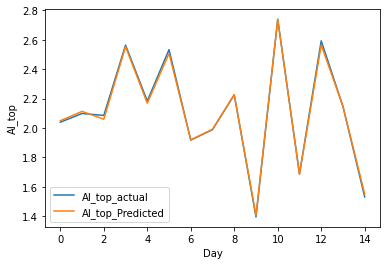

In [37]:
plt.plot(y_train, label='AI_top_actual')
plt.plot(predicted_train, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()

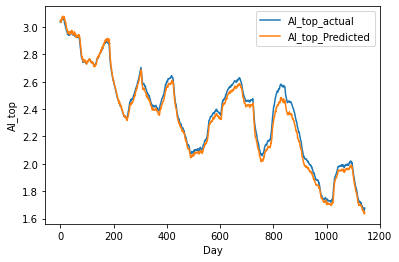

In [38]:
plt.plot(y_test, label='AI_top_actual')
plt.plot(predicted_test, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()

### LSTM

In [33]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(4, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(4, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [34]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0

In [35]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [36]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 4.161
Batch 200, Loss: 1.727
Val Loss: 0.480
***************************************************

Epoch: 2
Batch 100, Loss: 0.246
Batch 200, Loss: 0.179
Val Loss: 0.133
***************************************************

Epoch: 3
Batch 100, Loss: 0.063
Batch 200, Loss: 0.044
Val Loss: 0.044
***************************************************

Epoch: 4
Batch 100, Loss: 0.027
Batch 200, Loss: 0.020
Val Loss: 0.031
***************************************************

Epoch: 5
Batch 100, Loss: 0.015
Batch 200, Loss: 0.012
Val Loss: 0.027
***************************************************

Epoch: 6
Batch 100, Loss: 0.009
Batch 200, Loss: 0.008
Val Loss: 0.012
***************************************************

Epoch: 7
Batch 100, Loss: 0.006
Batch 200, Loss: 0.005
Val Loss: 0.005
***************************************************

Epoch: 8
Batch 100, Loss: 0.005
Batch 200, Loss: 0.003
Val Loss: 0.003
***************************************************

Epoch: 9

In [37]:
with torch.no_grad():
    predicted_train = model(X_train.to(device)).to('cpu').numpy()

In [38]:
with torch.no_grad():
    predicted_test = model(X_test.to(device)).to('cpu').numpy()


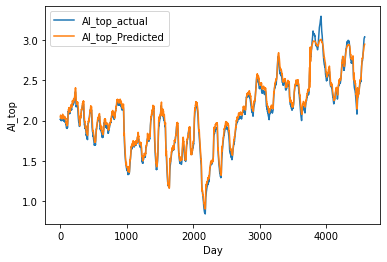

In [39]:
plt.plot(y_train, label='AI_top_actual')
plt.plot(predicted_train, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()

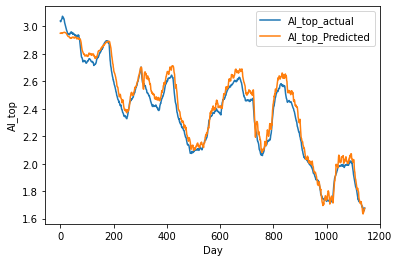

In [40]:
plt.plot(y_test, label='AI_top_actual')
plt.plot(predicted_test, label='AI_top_Predicted')
plt.xlabel('Day')
plt.ylabel('AI_top')
plt.legend()
plt.show()